In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import scipy
from scipy.stats import boxcox
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["svg.fonttype"] = "none"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start(

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.





Summary of the MLMR
                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               Spike_Nb  
No. Observations:               2976                  Method:                           REML      
No. Groups:                     96                    Scale:                            38.3247   
Min. group size:                31                    Log-Likelihood:                   -9856.9423
Max. group size:                31                    Converged:                        Yes       
Mean group size:                31.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept          

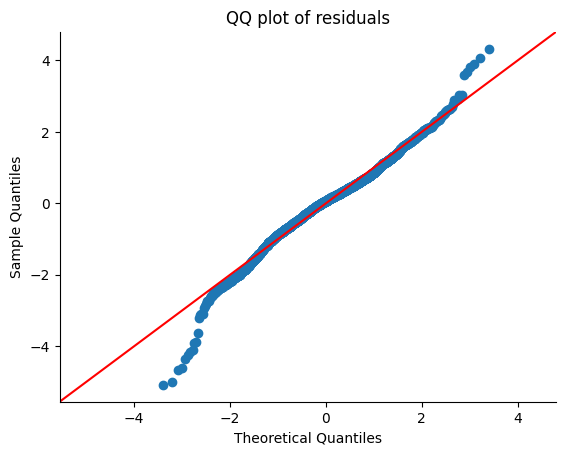



Pairwise Analyses for each injected current

Estimated marginal means at Injected_Current = 0:
  SHAM_Male: -2.2725
  IONL_Male: -2.8493
  SHAM_Female: -2.1935
  IONL_Female: -1.4587

Pairwise comparisons (adjusted for multiple testing):
Group1 vs Group2 | Mean Diff | SE Diff | t-stat | p-value | p-value_adj | Significant
SHAM_Male vs IONL_Male | 0.5768 | 2.5330 | 0.228 | 0.8199 | 0.9794 | False
SHAM_Male vs SHAM_Female | -0.0791 | 3.0589 | -0.026 | 0.9794 | 0.9794 | False
SHAM_Male vs IONL_Female | -0.8138 | 2.7948 | -0.291 | 0.7709 | 0.9794 | False
IONL_Male vs SHAM_Female | -0.6558 | 2.6866 | -0.244 | 0.8072 | 0.9794 | False
IONL_Male vs IONL_Female | -1.3906 | 2.3816 | -0.584 | 0.5593 | 0.9794 | False
SHAM_Female vs IONL_Female | -0.7348 | 2.9347 | -0.250 | 0.8023 | 0.9794 | False

Estimated marginal means at Injected_Current = 10:
  SHAM_Male: -1.6780
  IONL_Male: -1.9038
  SHAM_Female: -1.1638
  IONL_Female: 0.0207

Pairwise comparisons (adjusted for multiple testing):
Group1 v

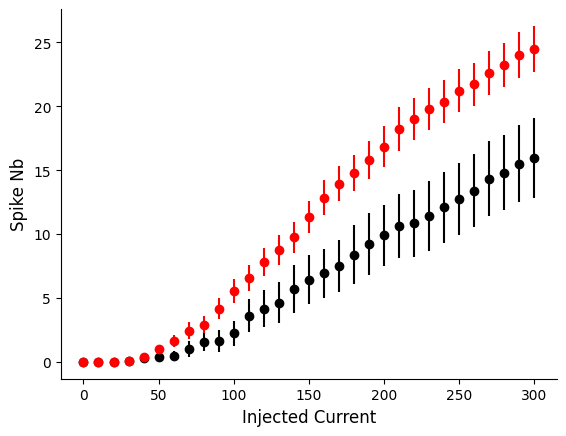



IO curve figure for Females


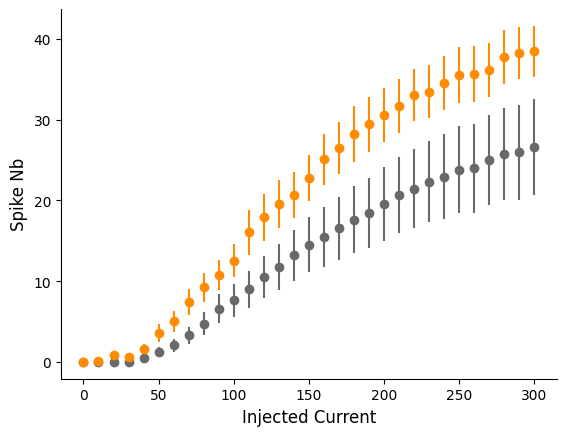

In [5]:
#Analyses full IO curves

df_taken=pd.read_csv('IOcurve_dataframe.csv')

list_categories_order=["SHAM_Male","IONL_Male","SHAM_Female","IONL_Female"]

#perform MLMR
df_taken["Animal_Condition_Sex"] = pd.Categorical(df_taken["Animal_Condition_Sex"], categories=list_categories_order)
model = mixedlm(
    "Spike_Nb ~ C(Animal_Condition_Sex) * Injected_Current",  # fixed effects
    data=df_taken,
    groups=df_taken["Cell_Name"],         # random intercepts per patient
    vc_formula={"Animal_Name": "0 + C(Animal_Name)"}
)
result = model.fit()
print()
print()
print('Summary of the MLMR')
print(result.summary())

# Add residuals and fitted values to your dataframe
df_taken["residuals"] = result.resid
df_taken["fitted"] = result.fittedvalues

# QQ plot of residuals
sm.qqplot(df_taken["residuals"], line="45", fit = True)
plt.title("QQ plot of residuals")
plt.show()




# === Define parameters for estimated marginal means calculation ===
categories = df_taken["Animal_Condition_Sex"].cat.categories.tolist()
intercept = result.params["Intercept"]
inj_cur_coef = result.params.get("Injected_Current", 0)

# Function to get coefficient or 0 if not present (e.g., reference category)
def get_coef(name):
    return result.params.get(name, 0)

print()
print()
print('Pairwise Analyses for each injected current')
list_inj_cur=[]
for i in range(31):
    list_inj_cur.append(i*10)
for inj_cur in list_inj_cur:
    
    # === Calculate estimated marginal means for each group at time inj_cur ===
    marginal_means = {}
    for cat in categories:
        cond_coef = get_coef(f"C(Animal_Condition_Sex)[T.{cat}]")
        interaction_coef = get_coef(f"C(Animal_Condition_Sex)[T.{cat}]:Injected_Current")
        mean = intercept + cond_coef + inj_cur_coef * inj_cur + interaction_coef * inj_cur
        marginal_means[cat] = mean
    
    print(f"\nEstimated marginal means at Injected_Current = {inj_cur}:")
    for k, v in marginal_means.items():
        print(f"  {k}: {v:.4f}")
    
    # === Prepare covariance matrix for contrasts ===
    cov = result.cov_params()
    
    # Degrees of freedom approximation:
    df_resid = result.df_resid if hasattr(result, "df_resid") else result.nobs - len(result.params)
    
    # === Compute pairwise contrasts ===
    alpha = 0.05
    pairwise_results = []
    
    for cat1, cat2 in combinations(categories, 2):
        
        # Difference in marginal means
        diff = marginal_means[cat1] - marginal_means[cat2]
        
        #compute manually var of marginal_means_diff
        if cat1==list_categories_order[0]:
            param_name_cat2 = "C(Animal_Condition_Sex)[T."+cat2+"]"
            param_name_cat2_IC = "C(Animal_Condition_Sex)[T."+cat2+"]:Injected_Current"
            list_var_diff=[
            cov[param_name_cat2][param_name_cat2],
            inj_cur*inj_cur*cov[param_name_cat2_IC][param_name_cat2_IC],
            2*inj_cur*cov[param_name_cat2][param_name_cat2_IC],
            ]
            var_diff=np.sum(list_var_diff)
            
        elif cat2==list_categories_order[0]:
            param_name_cat1 = "C(Animal_Condition_Sex)[T."+cat1+"]"
            param_name_cat1_IC = "C(Animal_Condition_Sex)[T."+cat1+"]:Injected_Current"
            list_var_diff=[
            cov[param_name_cat1][param_name_cat1],
            inj_cur*inj_cur*cov[param_name_cat1_IC][param_name_cat1_IC],
            2*inj_cur*cov[param_name_cat1][param_name_cat1_IC],
            ]
            var_diff=np.sum(list_var_diff)
        
        else:
            param_name_cat1 = "C(Animal_Condition_Sex)[T."+cat1+"]"
            param_name_cat2 = "C(Animal_Condition_Sex)[T."+cat2+"]"
            param_name_cat1_IC = "C(Animal_Condition_Sex)[T."+cat1+"]:Injected_Current"
            param_name_cat2_IC = "C(Animal_Condition_Sex)[T."+cat2+"]:Injected_Current"
            list_var_diff=[
            cov[param_name_cat1][param_name_cat1],
            cov[param_name_cat2][param_name_cat2],
            inj_cur*inj_cur*cov[param_name_cat1_IC][param_name_cat1_IC],
            inj_cur*inj_cur*cov[param_name_cat2_IC][param_name_cat2_IC],
            -2*cov[param_name_cat1][param_name_cat2],
            2*inj_cur*cov[param_name_cat1][param_name_cat1_IC],
            -2*inj_cur*cov[param_name_cat1][param_name_cat2_IC],
            -2*inj_cur*cov[param_name_cat2][param_name_cat1_IC],
            2*inj_cur*cov[param_name_cat2][param_name_cat2_IC],
            -2*inj_cur*inj_cur*cov[param_name_cat1_IC][param_name_cat2_IC],
            ]
            var_diff=np.sum(list_var_diff)
        

        
        se_diff = np.sqrt(var_diff)
        t_stat = diff / se_diff
        pval = 2 * scipy.stats.t.sf(np.abs(t_stat), df=df_resid)  # two-sided p-value
    
        pairwise_results.append((cat1, cat2, diff, se_diff, t_stat, pval))
    
    # === Multiple testing correction (Benjamini-Hochberg FDR) ===
    pvals = [x[5] for x in pairwise_results]
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    
    # === Print results ===
    print("\nPairwise comparisons (adjusted for multiple testing):")
    print("Group1 vs Group2 | Mean Diff | SE Diff | t-stat | p-value | p-value_adj | Significant")
    for i, (cat1, cat2, diff, se_diff, t_stat, pval) in enumerate(pairwise_results):
        print(f"{cat1} vs {cat2} | {diff:.4f} | {se_diff:.4f} | {t_stat:.3f} | {pval:.4g} | {pvals_corrected[i]:.4g} | {reject[i]}")



# build figures
print()
print()
print('IO curve figure for Males')
fig = plt.figure()

list_inj_cur=[]
for i in range(31):
    list_inj_cur.append(i*10)

list_animal_condition=["SHAM_Male","IONL_Male"]
for animal_condition in list_animal_condition:
    for inj_cur in list_inj_cur:
        df_trans = df_taken.loc[df_taken["Animal_Condition_Sex"]==animal_condition]
        df_trans = df_trans.loc[df_trans["Injected_Current"]==inj_cur]
        if animal_condition=="SHAM_Male":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="k")
        elif animal_condition=="IONL_Male":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="r")

plt.xlabel("Injected Current",fontsize=12)
plt.ylabel("Spike Nb",fontsize=12)
plt.savefig("IOcurve_male.svg")
plt.show()


print()
print()
print('IO curve figure for Females')
fig = plt.figure()

list_animal_condition=["SHAM_Female","IONL_Female"]
for animal_condition in list_animal_condition:
    for inj_cur in list_inj_cur:
        df_trans = df_taken.loc[df_taken["Animal_Condition_Sex"]==animal_condition]
        df_trans = df_trans.loc[df_trans["Injected_Current"]==inj_cur]
        if animal_condition=="SHAM_Female":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="dimgrey")
        elif animal_condition=="IONL_Female":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="darkorange")

plt.xlabel("Injected Current",fontsize=12)
plt.ylabel("Spike Nb",fontsize=12)
plt.savefig("IOcurve_female.svg")
plt.show()




Analyse of  Rheobase




C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)




Summary of the MLMR no BoxCox transformation
                        Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           Rheobase 
No. Observations:            96                Method:                       REML     
No. Groups:                  96                Scale:                        1884.9855
Min. group size:             1                 Log-Likelihood:               -515.5892
Max. group size:             1                 Converged:                    Yes      
Mean group size:             1.0                                                      
--------------------------------------------------------------------------------------
                                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------------
Intercept                               169.579   13.244 12.804 0.000  143.621 195.537
C(Animal_Condition_Se

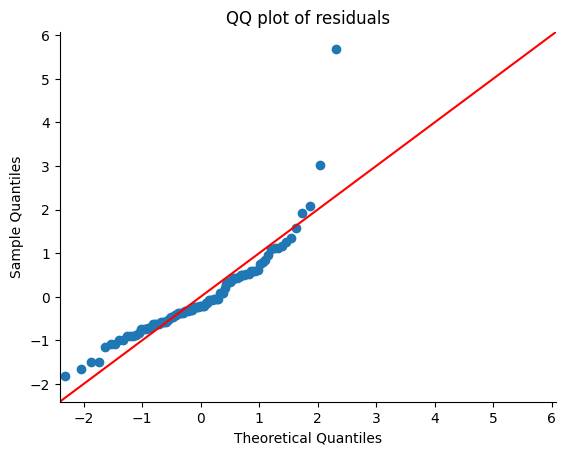



Summary of the MLMR with BoxCox transformation


C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Rheobase_bc
No. Observations:          96              Method:                     REML       
No. Groups:                96              Scale:                      0.2181     
Min. group size:           1               Log-Likelihood:             -98.6314   
Max. group size:           1               Converged:                  Yes        
Mean group size:           1.0                                                    
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               5.572    0.011 529.961 0.000  5.551  5.592
C(Animal_Condition_Sex)[T.IONL_Male]   -0.697    0.102  -6.809 0.000 -0.898 -0.497
C(Animal_Condition_Sex)[T.S

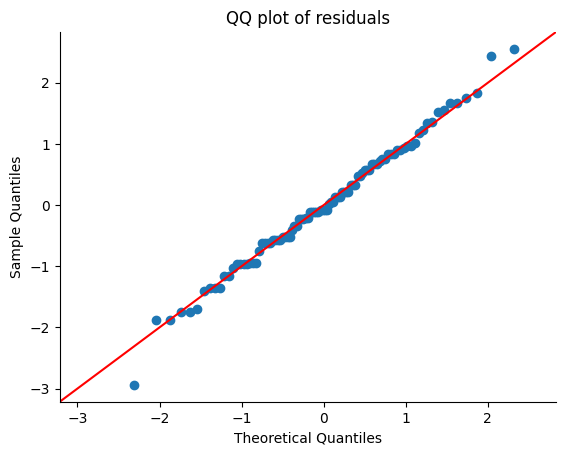

Estimated marginal means Box-Cox scale(fixed effects):
SHAM_Male: 5.571882779249239
IONL_Male: 4.874668195349176
SHAM_Female: 4.623877411848548
IONL_Female: 4.331416632345058

Pairwise comparisons:
Category1 vs Category2 | Mean Diff | SE Diff | t-stat | p-value | p-value (adj) | Significant
SHAM_Male vs IONL_Male | 0.6972 | 0.1024 | 6.809 | 0.0000 | 0.0000 | True
SHAM_Male vs SHAM_Female | 0.9480 | 0.1624 | 5.838 | 0.0000 | 0.0000 | True
SHAM_Male vs IONL_Female | 1.2405 | 0.1463 | 8.480 | 0.0000 | 0.0000 | True
IONL_Male vs SHAM_Female | 0.2508 | 0.1968 | 1.274 | 0.2059 | 0.2059 | False
IONL_Male vs IONL_Female | 0.5433 | 0.1741 | 3.120 | 0.0024 | 0.0036 | True
SHAM_Female vs IONL_Female | 0.2925 | 0.2147 | 1.362 | 0.1765 | 0.2059 | False


C:\Users\mizbili\AppData\Local\Temp\ipykernel_18448\3281010054.py:151: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(data=df_taken, x="Animal_Condition_Sex", y=param, errorbar="se", errcolor="k",
C:\Users\mizbili\AppData\Local\Temp\ipykernel_18448\3281010054.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_taken, x="Animal_Condition_Sex", y=param,


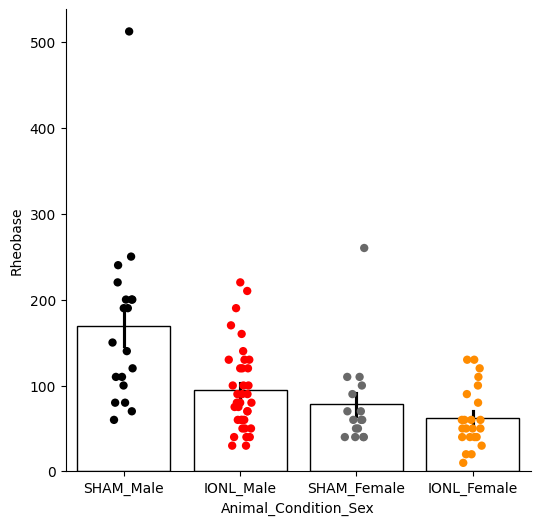

r2 regression SHAM_Male :  0.0007794967965879214
pvalue SHAM_Male :  0.9096677540979616
r2 regression IONL_Male :  0.0005327022055634441
pvalue IONL_Male :  0.8906022462207119
r2 regression SHAM_Female :  0.04771402515861835
pvalue SHAM_Female :  0.4163608206185805
r2 regression IONL_Female :  0.11192502404292382
pvalue IONL_Female :  0.11868108582475659


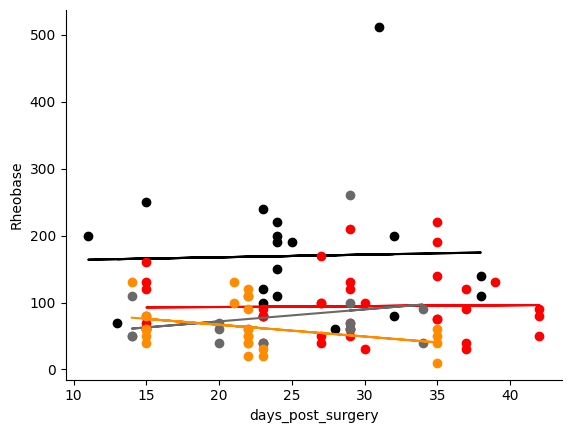









Analyse of  Gain




C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)




Summary of the MLMR no BoxCox transformation
                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         Gain   
No. Observations:           96              Method:                     REML   
No. Groups:                 96              Scale:                      0.0053 
Min. group size:            1               Log-Likelihood:             72.7185
Max. group size:            1               Converged:                  Yes    
Mean group size:            1.0                                                
-------------------------------------------------------------------------------
                                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                              0.097    0.022 4.384 0.000  0.054  0.141
C(Animal_Condition_Sex)[T.IONL_Male]   0.056    0.028 2.004 0.045  0.001  0.111
C(Animal_Condi

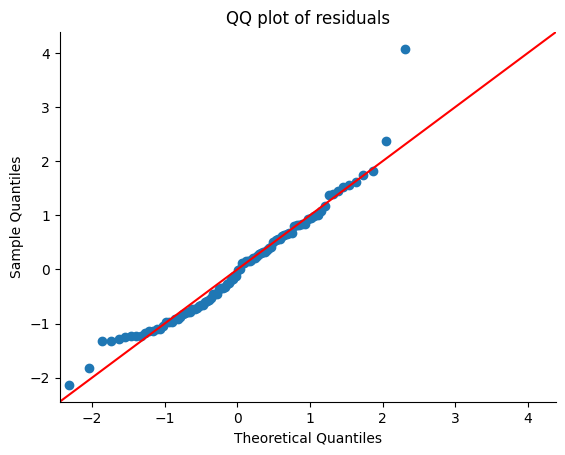



Summary of the MLMR with BoxCox transformation


C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          Gain_bc 
No. Observations:            96               Method:                      REML    
No. Groups:                  96               Scale:                       0.0446  
Min. group size:             1                Log-Likelihood:              -25.6572
Max. group size:             1                Converged:                   Yes     
Mean group size:             1.0                                                   
-----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                              -1.426    0.011 -127.068 0.000 -1.448 -1.404
C(Animal_Condition_Sex)[T.IONL_Male]    0.195    0.052    3.745 0.000  0.093  0.297
C(Animal_Condit

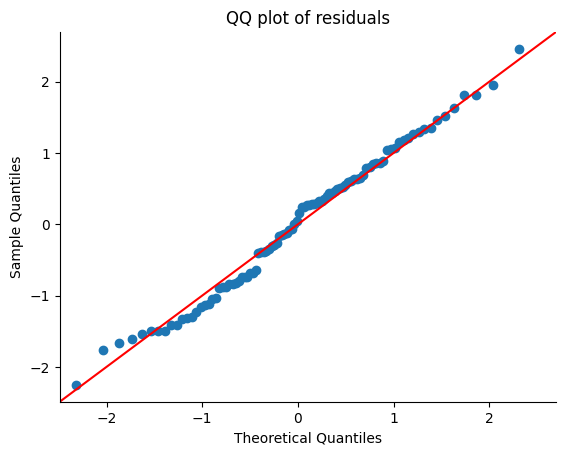

Estimated marginal means Box-Cox scale(fixed effects):
SHAM_Male: -1.4264712110819644
IONL_Male: -1.2317529520057136
SHAM_Female: -1.3333985069336038
IONL_Female: -0.9896162260762635

Pairwise comparisons:
Category1 vs Category2 | Mean Diff | SE Diff | t-stat | p-value | p-value (adj) | Significant
SHAM_Male vs IONL_Male | -0.1947 | 0.0520 | -3.745 | 0.0003 | 0.0009 | True
SHAM_Male vs SHAM_Female | -0.0931 | 0.0745 | -1.250 | 0.2145 | 0.2564 | False
SHAM_Male vs IONL_Female | -0.4369 | 0.0507 | -8.620 | 0.0000 | 0.0000 | True
IONL_Male vs SHAM_Female | 0.1016 | 0.0890 | 1.142 | 0.2564 | 0.2564 | False
IONL_Male vs IONL_Female | -0.2421 | 0.0781 | -3.101 | 0.0026 | 0.0038 | True
SHAM_Female vs IONL_Female | -0.3438 | 0.0969 | -3.548 | 0.0006 | 0.0012 | True


C:\Users\mizbili\AppData\Local\Temp\ipykernel_18448\3281010054.py:151: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(data=df_taken, x="Animal_Condition_Sex", y=param, errorbar="se", errcolor="k",
C:\Users\mizbili\AppData\Local\Temp\ipykernel_18448\3281010054.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_taken, x="Animal_Condition_Sex", y=param,


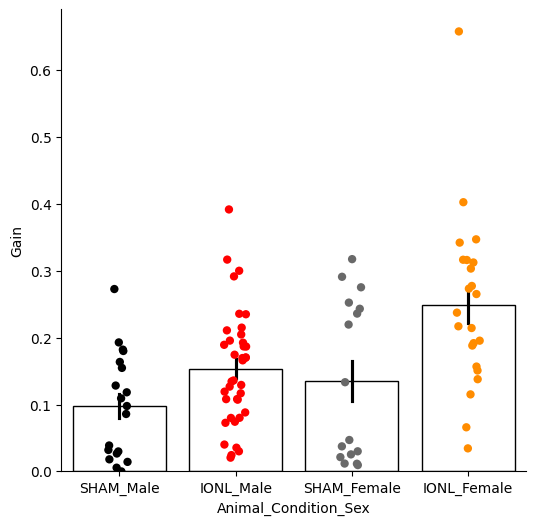

r2 regression SHAM_Male :  0.006187171636575736
pvalue SHAM_Male :  0.7489043975378803
r2 regression IONL_Male :  0.04020536403535339
pvalue IONL_Male :  0.22740959180118328
r2 regression SHAM_Female :  0.1307987858196462
pvalue SHAM_Female :  0.16868975549247417
r2 regression IONL_Female :  0.04374504942271071
pvalue IONL_Female :  0.3381755966470361


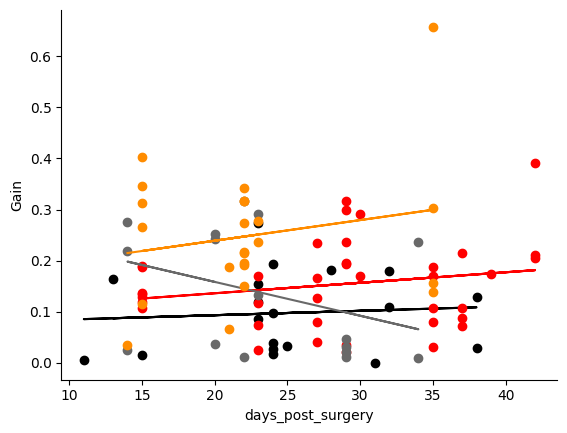

In [6]:
#Analyses full Rheobase and Gain

df_stats=pd.read_csv('Rheobase_Gain_dataframe.csv')

list_params=[
"Rheobase",
"Gain",
]

    
for param in list_params:
    print()
    print()
    print("Analyse of ",param)
    print()
    print()
    
    df_taken=df_stats.copy()
    df_taken=df_taken.dropna(subset=param)
    df_taken = df_taken.reset_index(drop=True)
    df_taken=df_taken.copy()

    df_taken["Animal_Condition_Sex"] = pd.Categorical(df_taken["Animal_Condition_Sex"], categories=["SHAM_Male","IONL_Male","SHAM_Female","IONL_Female"])
    model = mixedlm(
        param + " ~ C(Animal_Condition_Sex)",  # fixed effects
        data=df_taken,
        groups=df_taken["Cell_Name"],         # random intercepts per patient
        vc_formula={"Animal_Name": "0 + C(Animal_Name)"}
    )
    result = model.fit()
    print()
    print()
    print('Summary of the MLMR no BoxCox transformation')
    print(result.summary())

    # Add residuals and fitted values to your dataframe
    df_taken["residuals"] = result.resid
    df_taken["fitted"] = result.fittedvalues
    
    # QQ plot of residuals
    print()
    print()
    print('QQ plot no BoxCox transformation')
    sm.qqplot(df_taken["residuals"], line="45", fit = True)
    plt.title("QQ plot of residuals")
    plt.show()

    
    c_boxcox=0.1
    data_pos = df_taken[param] + c_boxcox
    bc_transformed, fitted_lambda = boxcox(data_pos)
    df_taken[param + "_bc"] = bc_transformed

    print()
    print()
    print('Summary of the MLMR with BoxCox transformation')
    df_taken["Animal_Condition_Sex"] = pd.Categorical(df_taken["Animal_Condition_Sex"], categories=["SHAM_Male","IONL_Male","SHAM_Female","IONL_Female"])
    model = mixedlm(
        param + "_bc" + " ~ C(Animal_Condition_Sex)",  # fixed effects
        data=df_taken,
        groups=df_taken["Cell_Name"],         # random intercepts per patient
        vc_formula={"Animal_Name": "0 + C(Animal_Name)"}
    )
    result = model.fit()
    print(result.summary())
    
    # Add residuals and fitted values to your dataframe
    df_taken["residuals"] = result.resid
    df_taken["fitted"] = result.fittedvalues
    
    # QQ plot of residuals
    print('QQ plot with BoxCox transformation')
    sm.qqplot(df_taken["residuals"], line="45", fit = True)
    plt.title("QQ plot of residuals")
    plt.show()
    
    # Get the fixed effect estimates:
    fe_params = result.params.filter(like="C(Animal_Condition_Sex)")
    
    # The base (reference) category intercept:
    intercept = result.params["Intercept"]
    
    # Extract all category names:
    categories = df_taken["Animal_Condition_Sex"].astype("category").cat.categories.tolist()
    
    # Construct estimated marginal means (group means) from params:
    # The reference category mean is intercept, others = intercept + coef
    marginal_means = {categories[0]: intercept}  # reference level
    
    for cat in categories[1:]:
        coef_name = f"C(Animal_Condition_Sex)[T.{cat}]"
        marginal_means[cat] = intercept + fe_params.get(coef_name, 0)
    
    print("Estimated marginal means Box-Cox scale(fixed effects):")
    for k, v in marginal_means.items():
        print(f"{k}: {v}")
    
    # Now compute all pairwise differences and p-values using covariance matrix and t-distribution
    cov = result.cov_params()
    
    def get_se_diff(cat1, cat2):
        # Variance of difference Var(b1 - b2) = Var(b1) + Var(b2) - 2*Cov(b1,b2)
        # "Intercept" is included, handle differences with intercept carefully
        
        if cat1 == categories[0] and cat2 == categories[0]:
            return 0  # same group
        elif cat1 == categories[0]:
            # difference = Intercept - (Intercept + b_cat2) = -b_cat2
            param = f"C(Animal_Condition_Sex)[T.{cat2}]"
            var_diff = cov.loc[param, param]
        elif cat2 == categories[0]:
            # difference = (Intercept + b_cat1) - Intercept = b_cat1
            param = f"C(Animal_Condition_Sex)[T.{cat1}]"
            var_diff = cov.loc[param, param]
        else:
            param1 = f"C(Animal_Condition_Sex)[T.{cat1}]"
            param2 = f"C(Animal_Condition_Sex)[T.{cat2}]"
            var1 = cov.loc[param1, param1]
            var2 = cov.loc[param2, param2]
            cov12 = cov.loc[param1, param2]
            var_diff = var1 + var2 - 2*cov12
    
        return np.sqrt(var_diff)
            
    alpha = 0.05
    df_resid = result.df_resid if hasattr(result, "df_resid") else result.nobs - len(result.params)
    
    pairwise_results = []
    
    for cat1, cat2 in combinations(categories, 2):
        diff = marginal_means[cat1] - marginal_means[cat2]
        se_diff = get_se_diff(cat1, cat2)
        t_stat = diff / se_diff
        
        # Two-sided p-value from t-distribution
        pval = 2 * scipy.stats.t.sf(np.abs(t_stat), df=df_resid)
        
        pairwise_results.append((cat1, cat2, diff, se_diff, t_stat, pval))
    
    # Multiple testing correction (e.g., Benjamini-Hochberg FDR)
    pvals = [x[5] for x in pairwise_results]
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    
    print("\nPairwise comparisons:")
    print("Category1 vs Category2 | Mean Diff | SE Diff | t-stat | p-value | p-value (adj) | Significant")
    for i, (cat1, cat2, diff, se_diff, t_stat, pval) in enumerate(pairwise_results):
        print(f"{cat1} vs {cat2} | {diff:.4f} | {se_diff:.4f} | {t_stat:.3f} | {pval:.4f} | {pvals_corrected[i]:.4f} | {reject[i]}")

    plt.figure(figsize=(6,6))
    # Bar plot (mean + error bars)
    sns.barplot(data=df_taken, x="Animal_Condition_Sex", y=param, errorbar="se", errcolor="k", 
                    order=["SHAM_Male","IONL_Male","SHAM_Female","IONL_Female"],
                    facecolor=[0,0,0,0], edgecolor="black")
    # Overlay scatter plot for individual points
    sns.stripplot(data=df_taken, x="Animal_Condition_Sex", y=param,
                      order=["SHAM_Male","IONL_Male","SHAM_Female","IONL_Female"],
                      palette=["k","r","dimgrey","darkorange"], size=6, jitter=True)
    plt.ylabel(param)
    plt.savefig(param+"_male_female.svg")
    plt.show()
    

    for animal_condition,color in zip(["SHAM_Male","IONL_Male","SHAM_Female","IONL_Female"],["k","r","dimgrey","darkorange"]):
        df_reg=df_taken.copy()
        df_reg=df_reg.loc[df_reg["Animal_Condition_Sex"] == animal_condition]
        df_reg=df_reg.dropna(subset="days_post_surgery")
        x=df_reg["days_post_surgery"]
        y=df_reg[param]
        res = scipy.stats.linregress(x, y)
        if res.pvalue<1:
            print("r2 regression "+animal_condition+" : ", res.rvalue**2)
            print("pvalue "+animal_condition+" : ", res.pvalue)
            plt.plot(df_reg["days_post_surgery"],df_reg[param],"o",color=color)
            plt.plot(x, res.intercept + res.slope*x,color=color)
            plt.ylabel(param)
            plt.xlabel("days_post_surgery")
    plt.savefig("correlation_"+param+"_male_female.svg")
    plt.show()


    print()
    print()
    print()
    print()
    print()
    print()

        